# Train Image Classifiers

In this notebook we will train an image classifier that classify fruit images, using MMClassificaiton.

## Prepare a Dataset

We have already prepared a dataset.

Credit to Zihao: https://github.com/TommyZihao/MMClassification_Tutorials

To download and extract the dataset, in command line:
```
curl -O https://zihao-openmmlab.obs.myhuaweicloud.com/20220716-mmclassification/dataset/fruit30/fruit30_split.zip
unzip -d data fruit30_split.zip
```

The dataset should be categorized by folders, for MMClassification to read.

## Prepare a Config and Checkpoint File

For speed consideration, we use a lightweight neural network, MobileNetV2.

we use mim to download the config file and checkpoint file.

```
mim download mmcls --config mobilenet-v2_8xb32_in1k --dest .
mv mobilenet-v2_8xb32_in1k.py mobilenet-v2_fruit.py
```

If you prefer to play with other models, navigate to [MMClassification model zoo](https://mmclassification.readthedocs.io/en/latest/model_zoo.html).

In [ ]:
!mim download mmcls --config mobilenet-v2_8xb32_in1k --dest .
!mv mobilenet-v2_8xb32_in1k.py mobilenet-v2_fruit.py

## Modify the Config File

1. Remove some intermediate item for clean: `dataset_type`, `img_norm_cfg`, `train_pipeline`, `test_pipeline`
1. Modify model
    1. number of class: from 1000 to 30
    2. pretrain weights: from None to the downloaded checkpoint file, as we finetune the model instead of training from scratch
1. Data: for train/val/test 
    1. `type`: `ImageNet` -> `CustomDataset`
    2. `prefix`, which is the root path to images: modify to `"data/fruit30_split/train"` or `"data/fruit30_split/val"`
    3. `ann_file`, use folder name as class name: modify to `None`
1. Runner and Optimizer
    1. number of training epochs: `runner.max_epochs`
    1. learning rates: `optimizer.lr`, usually divided by 8 due to linear scaling rules.
1. Misc
    1. Decrease `log_confg.interval` for small computation power
    1. Increase `checkpoint_config.interval` to avoid saving too many checkpoint, to same time and disk space
1. Further parameter tuning you may try
    1. learning rates: Decrease `optimizer.lr` for finetuning 
    1. configure learning scheduler to decrease learning when loss saturates. Moreover, by setting `by_epoch=False`, we decrease learning rate by iteration instead of by epoches.
    1. Monitor loss decrease and re-tune
    1. More available lr_schedulers are available in [mmcv](https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/lr_updater.py)

## Launch Training

In command line

```
mim train mmcls mobilenet-v2_fruit.py
```

In [ ]:
!mim train mmcls mobilenet-v2_fruit.py

## Understand Logs


The log is long but mainly contains the following parts:

1. Toolbox information
2. Dumped Config files
3. Model Initialization Logs
    1. Check `mmcls - INFO - load checkpoint from local path: mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth`, which means pretrained weights are loaded correctly.
4. Information on Hooks: we don't configure this explicitly in this tutorial, so ignore that
5. Training progress
    1. Training logs: including current learning, training loss, time consumption, memory occupation
    2. Validation logs: Accuracy on validation set

## Test the Model

The trained model (checkpoint file) is usually saved under `work_dirs/{experiment_name}/latest.pth`. 
We can load it to test with a new image. 

In [1]:
from mmcls.apis import init_model, inference_model

model = init_model('mobilenet-v2_flower.py', 'work_dirs/mobilenet-v2_flower/latest.pth')
result = inference_model(model, 'R-C.jpg')
print(result)

C:\Users\10728\anaconda3\envs\ptorch\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


load checkpoint from local path: work_dirs/mobilenet-v2_flower/latest.pth
{'pred_label': 4, 'pred_score': 0.9999986886978149, 'pred_class': 'tulip'}


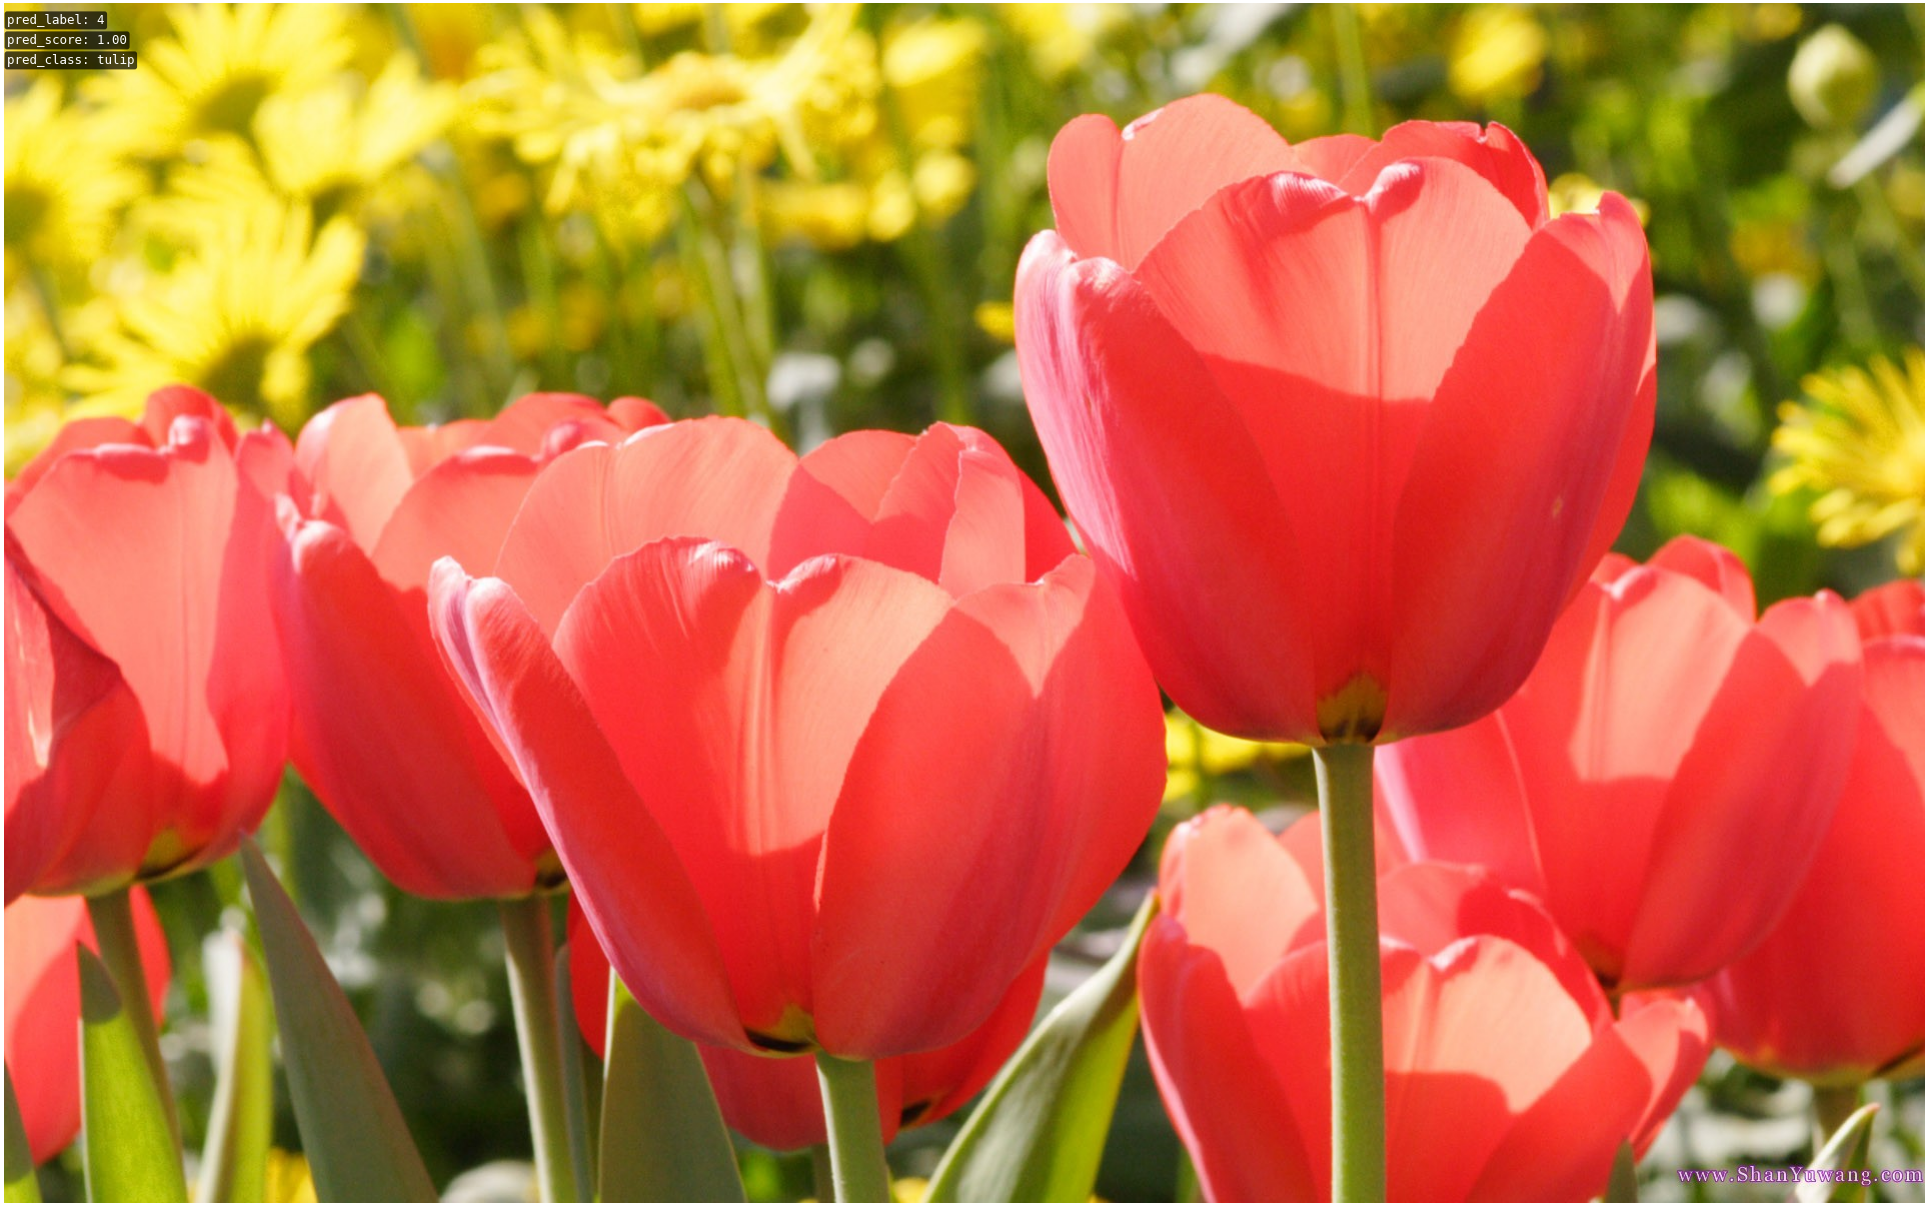

In [2]:
from mmcls.apis import show_result_pyplot

show_result_pyplot(model, 'R-C.jpg', result)

## PyTorch codes under the hood

### Runner

Runner construct the framework of training.

Specifically, MMClassification is based on `mmcv.EpochBasedRunner`.

## PyTorch codes under the hood

- train.py 
    - Process configs
    - Build dataset object
    - Build model object
    - call `mmcls.apis.train_model(model, dataset, cfg, **kwargs)`
        - Build dataloader object
        - Build optimizer object
        - Build runner via `runner.EpochBasedRunner(model, optimizer)`
        - Call `runner.run(dataloader)`
            - Fetch `batch` from `dataloader`
                - Data augmentation via `train_pipeline`
            - Call `losses = model.train_step(data_batch)`
            - `loss.backward()` and `optimizer.step()` in throuth `mmcv.OptimizerHook.after_train_iter()` hook

`tools/train.py`
```python
def main():
    model = build_classifier(cfg.model)
    model.init_weights()

    datasets = [build_dataset(cfg.data.train)]

    train_model(
        model,
        datasets,
        cfg,
        distributed=distributed,
        validate=(not args.no_validate),
        timestamp=timestamp,
        device=cfg.device,
        meta=meta)
```


`mmcls/apis/train_model.py`
```python
def train_model(model,
                dataset,
                cfg):
    
    data_loaders = [build_dataloader(ds, **train_loader_cfg) for ds in dataset]

    optimizer = build_optimizer(model, cfg.optimizer)
    
    runner = build_runner(
        cfg.runner,
        default_args=dict(
            model=model,
            optimizer=optimizer))
    
    runner.register_training_hooks(
        cfg.lr_config,
        optimizer_config,
        cfg.checkpoint_config,
        cfg.log_config,
        cfg.get('momentum_config', None),
        custom_hooks_config=cfg.get('custom_hooks', None))
    
    runner.run(data_loaders, cfg.workflow)
```


`mmcv/runner/epoch_based_runner.py`
```python
class EpochBasedRunner(BaseRunner):

    def run_iter(self, data_batch: Any, train_mode: bool, **kwargs) -> None:
        if train_mode:
            outputs = self.model.train_step(data_batch, self.optimizer, **kwargs)
        else:
            outputs = self.model.val_step(data_batch, self.optimizer, **kwargs)

        self.outputs = outputs

    def train(self, data_loader, **kwargs):
        self.model.train()
        self.data_loader = data_loader
        for i, data_batch in enumerate(self.data_loader):
            self.run_iter(data_batch, train_mode=True, **kwargs)
            self.call_hook('after_train_iter')
```


`mmcls/models/classifiers/base.py`
```python
class BaseClassifier(BaseModule, metaclass=ABCMeta):
    
    def forward(self, img, return_loss=True, **kwargs):
        """Calls either forward_train or forward_test depending on whether
        return_loss=True.

        Note this setting will change the expected inputs. When
        `return_loss=True`, img and img_meta are single-nested (i.e. Tensor and
        List[dict]), and when `resturn_loss=False`, img and img_meta should be
        double nested (i.e.  List[Tensor], List[List[dict]]), with the outer
        list indicating test time augmentations.
        """
        if return_loss:
            return self.forward_train(img, **kwargs)
        else:
            return self.forward_test(img, **kwargs)

    def train_step(self, data, optimizer=None, **kwargs):
        losses = self(**data)
        loss, log_vars = self._parse_losses(losses)

        outputs = dict(
            loss=loss, log_vars=log_vars, num_samples=len(data['img'].data))

        return outputs
```


`mmcls/models/classifiers/image.py`
```python
class ImageClassifier(BaseClassifier):
    
    def __init__(self,
                 backbone,
                 neck=None,
                 head=None,
                 pretrained=None,
                 train_cfg=None,
                 init_cfg=None):
        super(ImageClassifier, self).__init__(init_cfg)

        if pretrained is not None:
            self.init_cfg = dict(type='Pretrained', checkpoint=pretrained)
        self.backbone = build_backbone(backbone)

        if neck is not None:
            self.neck = build_neck(neck)

        if head is not None:
            self.head = build_head(head)

    def extract_feat(self, img):
        x = self.backbone(img)

        if self.with_neck:
            x = self.neck(x)
            
        return x

    def forward_train(self, img, gt_label, **kwargs):
        x = self.extract_feat(img)

        losses = dict()
        loss = self.head.forward_train(x, gt_label)

        losses.update(loss)

        return losses
```


`mmcv/runner/hooks/optimizer.py`
```python
class OptimizerHook(Hook):
    def after_train_iter(self, runner):
        runner.optimizer.zero_grad()
        runner.outputs['loss'].backward()
        runner.optimizer.step()
```